PyTorch Deep sort code is from Github https://github.com/ZQPei/deep_sort_pytorch

In [74]:
import torch
use_cuda = torch.cuda.is_available()
if use_cuda:
    device   = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")

Tesla T4


Load DeepSort code

In [75]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [76]:
!unzip -q "/content/gdrive/MyDrive/deep_sort_pytorch.zip" -d "/content"

replace /content/deep_sort_pytorch-master/.gitignore? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Read input video

In [79]:
from google.colab import files
uploaded = files.upload()

Saving short-video.mp4 to short-video.mp4


In [80]:
fnameLst = list(uploaded.keys())
fname = fnameLst[0]
print(fname)

short-video.mp4


In [164]:
import cv2
import imageio
import matplotlib.pyplot as plt
from IPython import display

cap = cv2.VideoCapture(fname)
total_frames = int(cap.get(7))
vid = imageio.get_reader(fname, 'ffmpeg')
fps = vid.get_meta_data()['fps']
print('No. of frames = ', total_frames)

No. of frames =  55


take a look at the input video

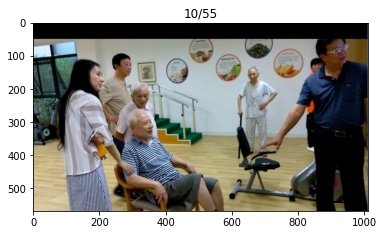

In [129]:
MaxFrame = 10
frame_count = 1
try:
  while(frame_count <= MaxFrame):
    display.clear_output(wait=True)
    plt.title(str(frame_count)+'/'+str(total_frames))
    frame = vid.get_data(frame_count)  # Capture frame-by-frame
    frame_count += 1
    plt.imshow(frame)
    plt.pause(0.1)
except:
    print("Read video error!")

In [82]:
%cd ./deep_sort_pytorch-master/
%ls

[Errno 2] No such file or directory: './deep_sort_pytorch-master/'
/content/deep_sort_pytorch-master
configs/    LICENSE            scripts/         yolov3_deepsort_eval.py
deep_sort/  ped_det_server.py  short-video.mp4  yolov3_deepsort.py
demo/       README.md          utils/
detector/   requirements.txt   webserver/


In [83]:
from detector import build_detector
from deep_sort import build_tracker
from utils.draw import draw_boxes
from utils.parser import get_config
from utils.log import get_logger
from utils.io import write_results

In [84]:
cfg = get_config("./configs/yolov3.yaml")
print(cfg)

{'YOLOV3': {'CFG': './detector/YOLOv3/cfg/yolo_v3.cfg', 'WEIGHT': './detector/YOLOv3/weight/yolov3.weights', 'CLASS_NAMES': './detector/YOLOv3/cfg/coco.names', 'SCORE_THRESH': 0.5, 'NMS_THRESH': 0.4, 'merge_from_file': <bound method YamlParser.merge_from_file of {...}>, 'merge_from_dict': <bound method YamlParser.merge_from_dict of {...}>}, 'merge_from_file': <bound method YamlParser.merge_from_file of {...}>, 'merge_from_dict': <bound method YamlParser.merge_from_dict of {...}>}


In [85]:
cfg.merge_from_file("./configs/deep_sort.yaml")

In [86]:
detector = build_detector(cfg, use_cuda=use_cuda)

In [87]:
deepsort = build_tracker(cfg, use_cuda=use_cuda)

#Understand code: Pass one img frame to deepsort
(You can skip this section and jump to the Main loop section)

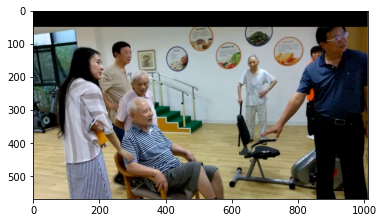

In [130]:
ori_im = vid.get_data(10)
plt.imshow(ori_im)
plt.show()

In [131]:
im = cv2.cvtColor(ori_im , cv2.COLOR_BGR2RGB)

In [132]:
bbox_xywh, cls_conf, cls_ids = detector(im)

In [133]:
print(bbox_xywh, "\n", cls_conf, "\n", cls_ids)

[[841.4976  292.39328 334.1053  511.95062]
 [678.08545 271.91364 121.12465 255.61078]
 [418.61545 362.6607  340.9723  379.43057]
 [190.66086 333.44727 258.46805 460.93253]
 [679.10315 420.07892 145.0351  244.73833]
 [332.7572  464.60815 238.29582 198.5671 ]] 
 [0.9873984 0.9851849 0.9614768 0.9515765 0.7456209 0.6237614] 
 [ 0  0  0  0 56 56]


In [134]:
# select person class
mask = cls_ids == 0
print(mask)

[ True  True  True  True False False]


In [135]:
# select person
bbox_xywh = bbox_xywh[mask]
# bbox dilation just in case bbox too small, delete this line if using a better pedestrian detector
#bbox_xywh[:, 3:] *= 1.2

cls_conf = cls_conf[mask]

print(bbox_xywh, "\n", cls_conf)

[[841.4976  292.39328 334.1053  511.95062]
 [678.08545 271.91364 121.12465 255.61078]
 [418.61545 362.6607  340.9723  379.43057]
 [190.66086 333.44727 258.46805 460.93253]] 
 [0.9873984 0.9851849 0.9614768 0.9515765]


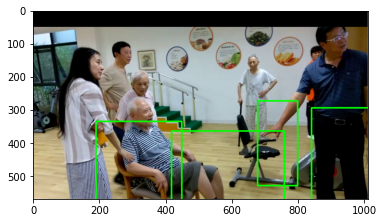

In [136]:
#show Yolo3 results
img0 = np.copy(ori_im)
if len(bbox_xywh) > 0:
  for elt in bbox_xywh:
    x0, y0, w, h = elt
    cv2.rectangle(img0, (x0, y0), (x0+w, y0+h), color=(0, 255, 0), thickness=3) 

plt.imshow(img0)
plt.show()

In [137]:
# do tracking
outputs = deepsort.update(bbox_xywh, cls_conf, im)

In [138]:
print(outputs, "\n", outputs[:, :4], "\n", outputs[:, -1])

[[ 65 106 309 564   2]] 
 [[ 65 106 309 564]] 
 [2]


In [145]:
# draw boxes for visualization
if len(outputs) > 0:
  bbox_xyxy = outputs[:, :4]
  identities = outputs[:, -1]
  ori_im = draw_boxes(ori_im, bbox_xyxy, identities)
  results.append((1, bbox_xyxy, identities))

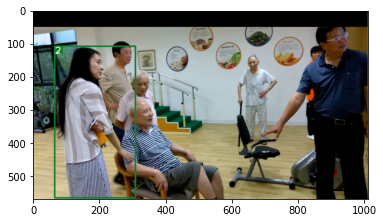

In [146]:
plt.imshow(ori_im)
plt.show()

In [154]:
save_format = '{frame},{id},{x1},{y1},{x2},{y2}\n'

In [156]:
# save results
with open("result.csv", 'w') as f:
  for frame_id, xyxys, track_ids in results:
    for xyxy, track_id in zip(xyxys, track_ids):
      if track_id < 0:
        continue
      x1, y1, x2, y2 = xyxy
      line = save_format.format(frame=frame_id, id=track_id, x1=x1, y1=y1,x2=x2, y2=y2)
      f.write(line)

#The main loop

Read video error!


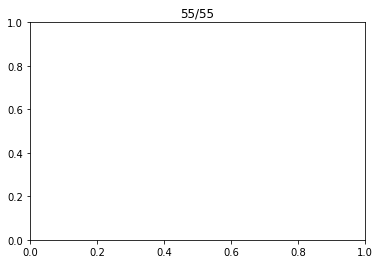

In [165]:
frame_count = 1
results = []
writer = imageio.get_writer("DeepSortResult.mp4", fps=fps)
try:
  while(frame_count < total_frames):
    display.clear_output(wait=True)
    plt.title(str(frame_count)+'/'+str(total_frames))
    ori_im = vid.get_data(frame_count)  # Capture frame-by-frame
    img1 = np.copy(ori_im)
    im = cv2.cvtColor(ori_im,cv2.COLOR_BGR2RGB)
    bbox_xywh, cls_conf, cls_ids = detector(im)

    # select person class
    mask = cls_ids == 0
    bbox_xywh = bbox_xywh[mask]
    #bbox_xywh[:, 3:] *= 1.2
    cls_conf = cls_conf[mask]

    # do tracking
    outputs = deepsort.update(bbox_xywh, cls_conf, im)

    # draw boxes for visualization
    if len(outputs) > 0:
      bbox_xyxy = outputs[:, :4]
      identities = outputs[:, -1]
      img1 = draw_boxes(img1, bbox_xyxy, identities)
      results.append((frame_count, bbox_xyxy, identities))

    img = np.append(ori_im, img1, axis=1) #把 2 張 img 接起來
    writer.append_data(img)

    frame_count += 1
    plt.imshow(img)                     
    plt.pause(0.1)
except:
    print("Read video error!")
writer.close()

In [166]:
# save results
save_format = '{frame},{id},{x1},{y1},{x2},{y2}\n'
with open("DeepSortResult.csv", 'w') as f:
  for frame_id, xyxys, track_ids in results:
    for xyxy, track_id in zip(xyxys, track_ids):
      if track_id < 0:
        continue
      x1, y1, x2, y2 = xyxy
      line = save_format.format(frame=frame_id, id=track_id, x1=x1, y1=y1,x2=x2, y2=y2)
      f.write(line)